In [1]:
from __future__ import print_function, division
%matplotlib inline

# import used packages and modules
# import display function to display the table of the pandas dataframe
from IPython.display import display

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, confusion_matrix

from scipy import signal

from hmmlearn import hmm
from seqlearn.hmm import MultinomialHMM

import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import csv






/Users/mihaivisuian/miniconda3/envs/hons/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train_manchester = pd.read_csv('../data/misc/Train_Manchester_Northwich.csv')
london_data = pd.read_csv('../data/london_data/london_data.csv')

data04 = pd.read_csv('../data/meadows_december/meadows-2017-12-04.csv')
data05 = pd.read_csv('../data/meadows_december/meadows-2017-12-05.csv')
data06 = pd.read_csv('../data/meadows_december/meadows-2017-12-06.csv')
data07 = pd.read_csv('../data/meadows_december/meadows-2017-12-07.csv')

bike_data_old = pd.read_csv('../data/misc/2015061911.csv')
bike_data_old2 = pd.read_csv('../data/misc/2015061817.csv')
bike_data_feb = pd.read_csv('../data/misc/bike_feb.csv')

In [3]:
bin_vals = ['bin'+str(x) for x in range(0,16)]
pm_vals = ['pm1', 'pm2_5', 'pm10']

## Merging Data

In [4]:
# environment index is 0 as all data from these datasets is walking data
data04['environment_index'] = 0
data05['environment_index'] = 0
data06['environment_index'] = 0
data07['environment_index'] = 0

# environment index is 3 for bike data
bike_data_old['environment_index'] = 3
bike_data_old2['environment_index'] = 3
bike_data_feb['environment_index'] = 3

# rename columns
bike_data_old2 = bike_data_old2.rename(
    index=str, columns={"latitude":'gpsLatitude', "longitude":'gpsLongitude'})

labels = bin_vals + pm_vals + ['environment_index', 'gpsLatitude', 'gpsLongitude', 'humidity']

data = pd.concat([london_data[labels],
                  train_manchester[labels], 
                  data04[labels], 
                  data05[labels],
                  data06[labels],
                  data07[labels],
                  bike_data_old[labels],
                  bike_data_old2[labels],
                  bike_data_feb[labels]], ignore_index=True)

# remove indoor labelled data for this set of experiments
data = data[data['environment_index']!=7]
data = data[data['environment_index']!=5]
data = data[data['humidity']>0]

## Plots

In [50]:
def plot_bins(indexes, location, titles):
    
    fig = plt.figure(figsize=(12,12))
    for idx, environment_index in enumerate(indexes):
        env_data = data[data['environment_index']==environment_index]
        normalised_env_data = env_data.copy().reindex()
        normalised_env_data[bin_vals] = normalised_env_data[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

        ax1 = fig.add_subplot(3, 2, idx+1)
        normalised_env_data[bin_vals].describe().loc['mean'].plot(kind='bar')
        ax1.set_title("Normalised Bin Counts for {} Data".format(titles[idx]))
    fig.tight_layout()
    fig.savefig(location)

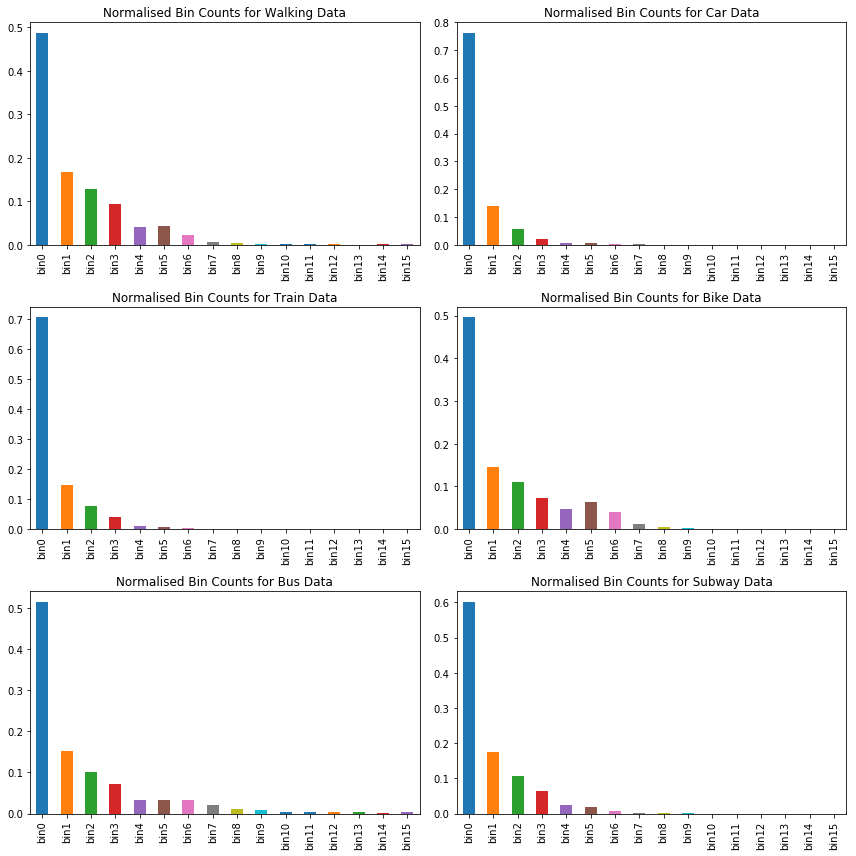

In [51]:
titles=['Walking', 'Car', 'Train', 'Bike', 'Bus', 'Subway']
plot_bins([0, 1, 2, 3, 4, 6], titles=titles, location='../report/norm_bins.pdf')

## Bike bins in different weather conditions

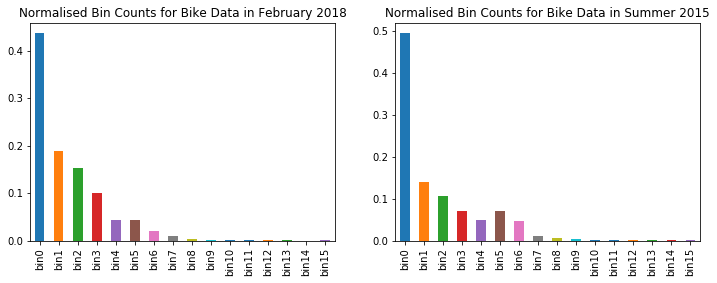

In [70]:
bike_data_feb_norm = bike_data_feb.copy().reindex()
bike_data_feb_norm[bin_vals] = bike_data_feb_norm[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

bike_data_old = pd.concat([bike_data_old, bike_data_old2], ignore_index=True)
bike_data_old_norm = bike_data_old.copy().reindex()
bike_data_old_norm[bin_vals] = bike_data_old_norm[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Normalised Bin Counts for Bike Data in February 2018')
bike_data_feb_norm[bin_vals].describe().loc['mean'].plot(kind='bar')

ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Normalised Bin Counts for Bike Data in Summer 2015')
bike_data_old_norm[bin_vals].describe().loc['mean'].plot(kind='bar')


## Time series plots

In [64]:
def get_time_from_timestamp(timestamp):
    return datetime.datetime.fromtimestamp(timestamp/1000.).time()

In [153]:
# time series plot
def time_series_plot(fig, fig_indexes, dataset, title=""):
    # midday times
    try:
        times = list(map(lambda x: datetime.datetime.strptime(str(x), '%H:%M:%S.%f'), dataset[0][0]['time']))
    except ValueError:
        times = list(map(lambda x: datetime.datetime.strptime(str(x), '%H:%M:%S'), dataset[0][0]['time']))

    ax = fig.add_subplot(fig_indexes)
    # graphs initialisation
    for d, key, label in dataset:
        if key != '':
            ax.plot(times, d[key], label=label)
        else:
            ax.plot(times, d, label=label)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.xticks(rotation=60)
    plt.title(title)
    ax.legend()


### Meadows afternoon data

In [154]:
data05['time'] = data05['phoneTimestamp'].apply(lambda row: get_time_from_timestamp(row))
sorted_data = data05.sort_values('time').reset_index()
midday_data = sorted_data[sorted_data['time'] < datetime.time(15+2)]
afternoon_data = sorted_data[sorted_data['time'] >= datetime.time(15+2)]

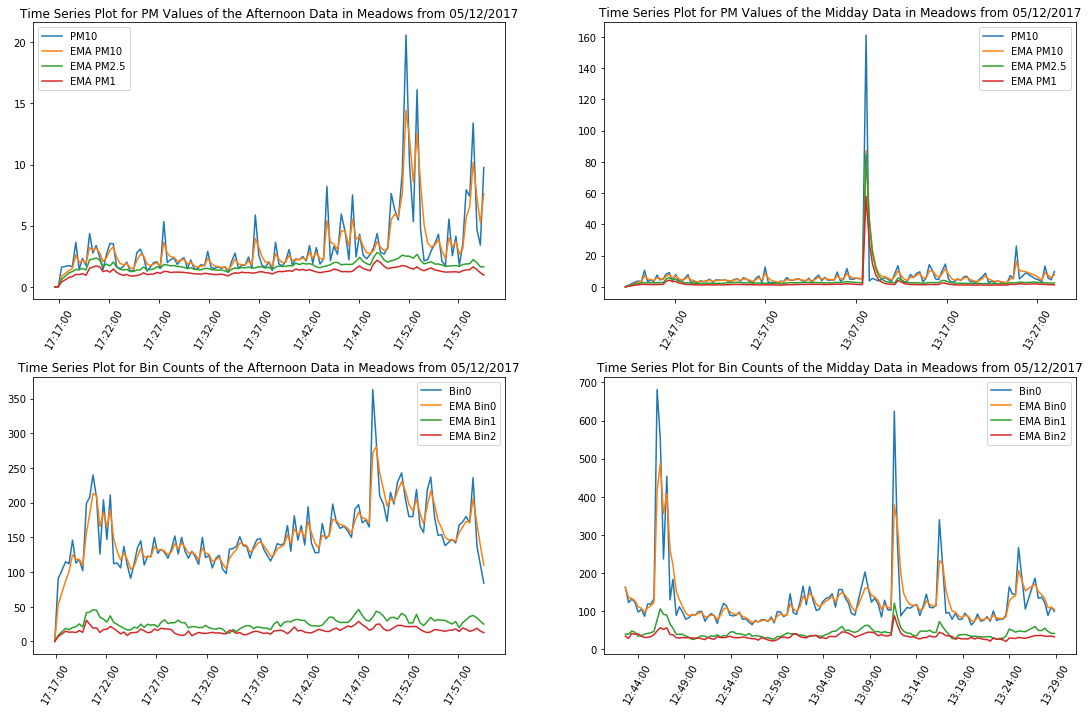

In [156]:
f1 = plt.figure(figsize=(16,10))

time_series_plot(f1, 221, [
    (afternoon_data, 'pm10', 'PM10'),
    (afternoon_data['pm10'].ewm(com=0.9).mean(), '', 'EMA PM10'),
    (afternoon_data['pm2_5'].ewm(com=0.9).mean(), '', 'EMA PM2.5'),
    (afternoon_data['pm1'].ewm(com=0.9).mean(), '', 'EMA PM1'),
], title="Time Series Plot for PM Values of the Afternoon Data in Meadows from 05/12/2017")

time_series_plot(f1, 222, [
    (midday_data, 'pm10', 'PM10'),
    (midday_data['pm10'].ewm(com=0.9).mean(), '', 'EMA PM10'),
    (midday_data['pm2_5'].ewm(com=0.9).mean(), '', 'EMA PM2.5'),
    (midday_data['pm1'].ewm(com=0.9).mean(), '', 'EMA PM1'),
], title="Time Series Plot for PM Values of the Midday Data in Meadows from 05/12/2017")

fl = afternoon_data[afternoon_data['bin0']<1000]
time_series_plot(f1, 223, [
    (fl, 'bin0', 'Bin0'),
    (fl['bin0'].ewm(com=0.9).mean(), '', 'EMA Bin0'),
    (fl['bin1'].ewm(com=0.9).mean(), '', 'EMA Bin1'),
    (fl['bin2'].ewm(com=0.9).mean(), '', 'EMA Bin2'),
], title="Time Series Plot for Bin Counts of the Afternoon Data in Meadows from 05/12/2017")

fl2 = midday_data[midday_data['bin0']<1000]
time_series_plot(f1, 224, [
    (fl2, 'bin0', 'Bin0'),
    (fl2['bin0'].ewm(com=0.9).mean(), '', 'EMA Bin0'),
    (fl2['bin1'].ewm(com=0.9).mean(), '', 'EMA Bin1'),
    (fl2['bin2'].ewm(com=0.9).mean(), '', 'EMA Bin2'),
], title="Time Series Plot for Bin Counts of the Midday Data in Meadows from 05/12/2017")

plt.tight_layout()
plt.show()
f1.savefig('../report/time_series_meadows.pdf')

### London Data

In [159]:
def get_time_string(date):
    return datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S.%f").time().strftime("%H:%M:%S")

In [228]:
def plot_data(fig, fig_indexes, dataset, title=""):
    times = list(map(lambda x: datetime.datetime.strptime(get_time_string(x), "%H:%M:%S"), dataset[0][0]['phoneTimestamp']))
    
    ax = fig.add_subplot(fig_indexes)
    for d, key, label in dataset:
        if key != "":
            ax.plot(times, d[key].astype(float), label=label)
        else:
            ax.plot(times, d.astype(float), label=label)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.xticks(rotation=60)
    plt.title(title)
    plt.axvline(times[26], label='Walking', linestyle='--', color='red')
    plt.axvline(times[53], label='Bus', linestyle='--', color='purple')
    plt.axvline(times[110], linestyle='--', color='red')
    plt.axvline(times[863], label='Train', linestyle='--', color='cyan')
    plt.axvline(times[879], linestyle='--', color='red')
    plt.axvline(times[954], label='Subway', linestyle='--', color='orange')
    plt.axvline(times[1792], linestyle='--', color='red')
    plt.axvline(times[-1], label='Indoor', linestyle='--', color='grey')
    ax.legend()

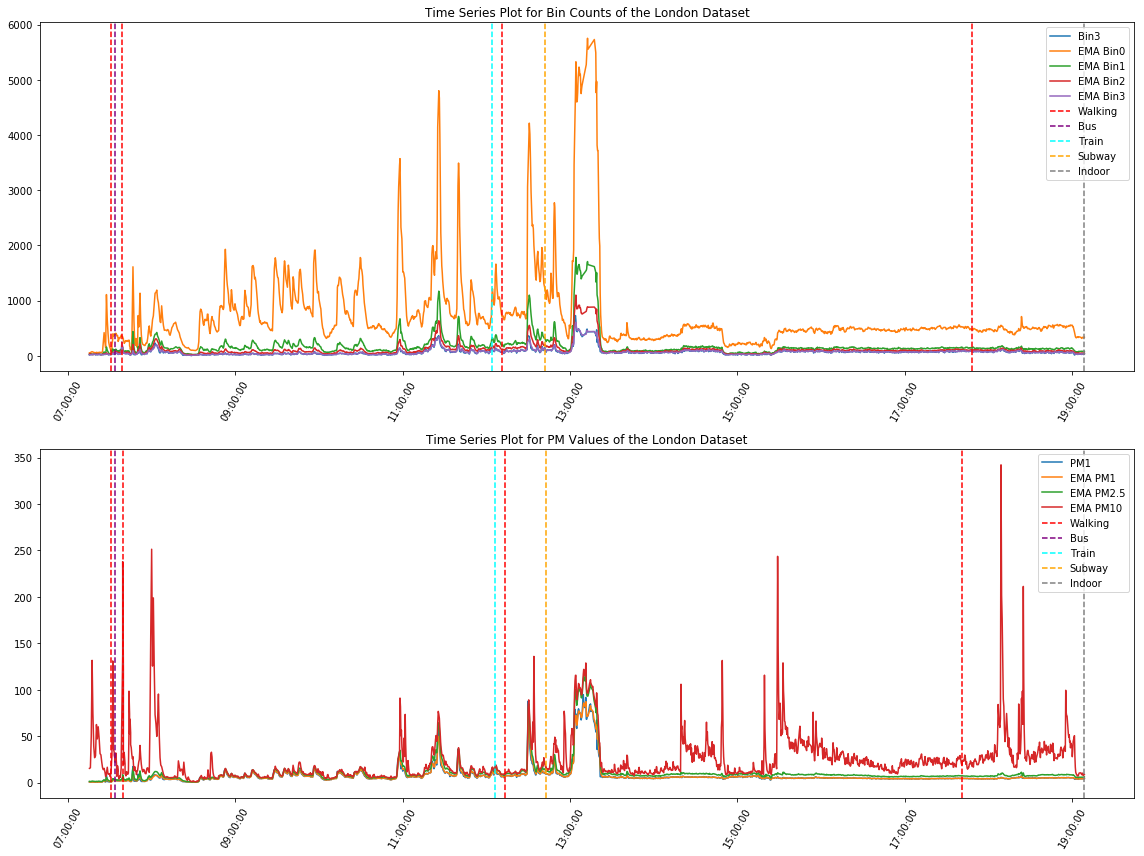

In [229]:
filtered_data = london_data[london_data['phoneTimestamp']>'2017-11-22'].copy().reindex()
filtered_pms = filtered_data[filtered_data['pm10']<800].copy().reindex()
filtered_bins = filtered_data[filtered_data['bin0']<6000].copy().reindex()

# filtered_bins[bin_vals] = filtered_bins[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

f2 = plt.figure(figsize=(16,12))

plot_data(f2, 211, [
    (filtered_bins, 'bin3', 'Bin3'),
    (filtered_bins['bin0'].ewm(com=0.9).mean(), '', 'EMA Bin0'),
    (filtered_bins['bin1'].ewm(com=0.9).mean(), '', 'EMA Bin1'),
    (filtered_bins['bin2'].ewm(com=0.9).mean(), '', 'EMA Bin2'),
    (filtered_bins['bin3'].ewm(com=0.9).mean(), '', 'EMA Bin3'),
], title="Time Series Plot for Bin Counts of the London Dataset")

plot_data(f2, 212, [
    (filtered_pms, 'pm1', 'PM1'),
    (filtered_pms['pm1'].ewm(com=0.9).mean(), '', 'EMA PM1'),
    (filtered_pms['pm2_5'].ewm(com=0.9).mean(), '', 'EMA PM2.5'),
    (filtered_pms['pm10'].ewm(com=0.9).mean(), '', 'EMA PM10'),
], title="Time Series Plot for PM Values of the London Dataset")

f2.tight_layout()
f2.savefig('../report/time_series_london.pdf')